In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim

plt.rcParams.update({'font.size': 22})
pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [2]:
data = simplesim.Manager( directory="./data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="diag", filetype="nc")
plot = simplesim.Manager( executable ="./feltorplot.sh", directory="plot", filetype = "nc")

In [3]:
content = data.table()
print( f"The database contains {np.size(content)} elements")

The database contains 2 elements


In [4]:
config = fp.load_default_config()

with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [5]:
for file in content : 
    diag.create(file)
    plot.create(file)

{'R_0': 545.0, 'beta': 0.0001, 'epsilon_D': 4.1458919332419e-05, 'mu': -0.00027244371074816386, 'resistivity': 0.0001, 'tau': 1.0, 'viscosity': 'braginskii'}
Invert for given numerical parameters
{'beta': 0.0001, 'epsilon_D': 4.1458919332419e-05, 'mu': -0.00027244371074816386, 'resistivity': 0.0001, 'tau': 1.0, 'viscosity': 'braginskii', 'm_i': 3.3435837204626655e-27, 'T_e': 7.7760885116595384, 'T_i': 7.7760885116594887, 'n_0': 1.0365292425429586, 'B_0': 0.40283899536537354, 'R': 0.5449999991654868}
Average flux is  0.0014182083893 0.00077194756281
Total average mass loss rate is  6975.25288821
particle confinement time =  0.0326503874525
Area =  31.9816059811 Volume =  8.19537991811 mass =  4.59450105954
{'R_0': 545.0, 'beta': 0.0001, 'epsilon_D': 4.1458919332419e-05, 'mu': -0.00027244371074816386, 'resistivity': 0.0001, 'tau': 1.0, 'viscosity': 'braginskii'}
Invert for given numerical parameters
{'beta': 0.0001, 'epsilon_D': 4.1458919332419e-05, 'mu': -0.00027244371074816386, 'resist

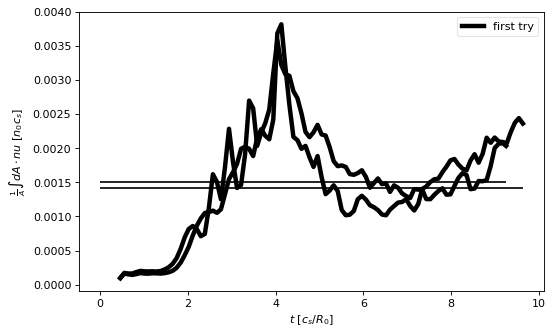

Average flux  [ 0.00150612  0.00141821]
Sigma flux  [ 0.00078769  0.00077195]
Confinement time  [ 0.0307239   0.03265039]


In [20]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion
min_idx = 5
confinement_time = np.array([])
average_flux = np.array([])
sigma_flux = np.array([])

fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :
    #dd = Dataset( data.outfile(file), 'r')
    da = Dataset( diag.outfile(file), "r")
    #pl = nc.Dataset( plot.outfile(file), "r")
    
    #print( dset)
    pp = json.loads( da.inputfile )
    time = da['time'][:]
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    rho = da['rho'][:]
    area = da['psi_area'][:]
    volume = da['psi_vol'][:]
    
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    print(num)
    fp.numerical2physical( num, pp['physical'])
    print( pp["physical"])
    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0'] # R_0 / c_s
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =da['electrons_ifs_lcfs'][:]
    average_mass = np.mean(mass)
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    # jvne= dset.variables['jvneE_tt_fsa'][:,:]
    jvne=da['jvneC_tt_ifs_lcfs'][:]/deltat
    jvne+=da['jvneE_tt_ifs_lcfs'][:]/deltat
    jvne+=da['jvneA_tt_ifs_lcfs'][:]/deltat
    divjvne = da["divjnepar_tt_ifs_lcfs"][:]/deltat
    average_jvne = jvne[min_idx:].mean() # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    source = da["sne_tt_ifs_lcfs"][:]/deltat
    average_source = source[min_idx:].mean()
    print( "Average flux is " , average_jvne/area[167], sigma_jvne/area[167])
    print( "Total average mass loss rate is ", average_jvne)
    #print( "Total mass gain by sources is",  average_source )
    average_flux = np.append( average_jvne/area[167], average_flux )
    sigma_flux = np.append( sigma_jvne/area[167], sigma_flux )
    print( "particle confinement time = ", average_mass/average_jvne*1e-7)
    confinement_time = np.append( average_mass/average_jvne*1e-7, confinement_time )
    tau = mass/jvne
    idx = 167
    rhos = 2.55e-3
    print( "Area = ", rhos**2*area[idx], "Volume = ", rhos**3*volume[idx], "mass = ", mass[0]/volume[idx])

    # source = dset.variables['sne_tt_ifs'][:,:]
    # diff_perp = dset.variables["lneperp_tt_ifs"][:,:]
    # diff_para = dset.variables["lneparallel_tt_ifs"][:,:]
    # diff = deltamass + jvne - source - diff_perp-diff_para
    # accuracy = np.abs(diff) / np.abs(deltamass)# + diff_perp+diff_para - jvne + source)
   
    # cum_jvne = np.cumsum( jvne, axis=0)
    # cum_diff_perp = np.cumsum( diff_perp, axis=0)


    # plt.plot(time[1:],accuracy[1:,idx], color=v[0], marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, label=v[1])
#    plt.plot(time[1:],deltamass[1:,idx]-source[1:,idx], color=v[0], marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, label=v[1])
    plt.plot(time[min_idx:]*timescale,jvne[min_idx:]/area[idx], color='k', 
             marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, label='first try')
    plt.hlines(average_jvne/area[idx], time[0]*timescale, time[len(time)-1]*timescale, color='k')#, ls='--', lw=2, )
    # plt.plot(time[1:]*4.56e-3,tau[1:]*5e-8 , color=v[0], marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, label=v[1])
#    plt.plot(time[1:],diff_perp[1:,idx], color=v[0], marker='',ls='--', lw=4,markeredgecolor='k', markersize=8, label=v[1])
#    plt.plot(time[1:],source[1:,idx], color=v[0], marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, label=v[1])
    # plt.plot(time[1:],mass[1:,idx], color=v[0], marker='',ls='-',markeredgecolor='k', markersize=8, label=v[1])
    # idx= 41
    # print( rho[idx])
#    plt.plot(time[min_idx :],jvne[min_idx:,idx], color=v[0], marker='',ls='-',lw=4,markeredgecolor='k', markersize=8, label=v[1])
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
plt.xlabel(r"$t\ [c_s/R_0]$")
plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
#plt.xlim(15,100)
#plt.ylim(0,0.025)
# plt.ylim(0,30000)
plt.show(   )
print( "Average flux ", average_flux)
print( "Sigma flux ", sigma_flux)
print( "Confinement time ", confinement_time)

tau=  1.0 beta =  0.0001 C =  0.0001
Average diff =  -85.9657319203
Rho 0.997987470261
tau=  1.0 beta =  0.0001 C =  0.0001
Average diff =  -85.4527896062
Rho 0.997987470261


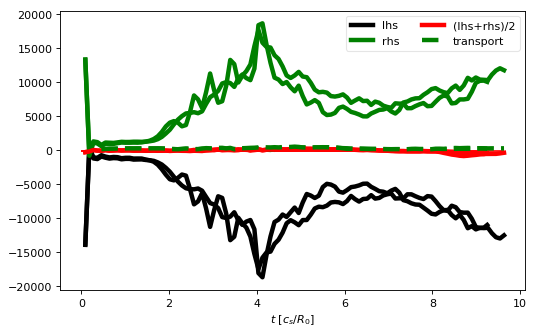

In [22]:

fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :
    dset = Dataset( diag.outfile(file), 'r')
    #print( dset)
    params = json.loads( dset.inputfile )
    time = dset['time'][:]
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    rho = dset['rho'][:]
    area = dset['psi_area'][:]
    volume = dset['psi_vol'][:]
    #print(rho)

    print("tau= ", params['physical']['tau'], "beta = ", params['physical']['beta'], "C = ", params['physical']['resistivity'])
    
    mass =dset.variables['electrons_ifs_lcfs'][:]
    masstt=np.append(np.zeros(1),mass, axis=0)
    # mass = (mass - mass[,:])
    #print( np.shape( mass))  
    # masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    #print( np.shape( mass))
    deltamass = np.diff(masstt,axis=0)/deltat
    source = dset.variables['sne_tt_ifs_lcfs'][:]/deltat
    deltamass-=source
    #print( np.shape( dmassdt))
    jvne= dset['jvneE_tt_ifs_lcfs'][:]/deltat
    jvne+=dset['jvneC_tt_ifs_lcfs'][:]/deltat
    jvne+=dset['jvneA_tt_ifs_lcfs'][:]/deltat
    divjvnepar=dset['divjnepar_tt_ifs_lcfs'][:]/deltat
    #jvne+=divjvnepar

    diff_perp = dset["lneperp_tt_ifs_lcfs"][:]/deltat
    rhs = jvne-diff_perp
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean(diff[1:])
    print( "Average diff = ", average_diff)
    print( "Rho", rho[idx])
    plt.plot(time[1:]*timescale,deltamass[1:], color='k', marker='',
              ls='-', lw=4,markeredgecolor='k', markersize=8, label="lhs")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=4,markeredgecolor='g', markersize=8, label="rhs")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=4,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
    plt.plot(time[min_idx:]*timescale,divjvnepar[min_idx:], color='g', marker='',
               ls='--', lw = 4, label="parallel")
    # plt.plot(time[min_idx:]*timescale,jvne_lcfs[min_idx:,idx], color='g', marker='',
    #           ls='-.', lw = 4, label="transport")

    # idx= 41
    # print( rho[idx])
    # plt.plot(time[min_idx :]*timescale,jvne[min_idx:,idx], color=v[0], marker='',ls='-',lw=4,markeredgecolor='k', markersize=8, label=v[1])
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    
plt.xlabel(r"$t\ [c_s/R_0]$")
# plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
# plt.xlim(8500,9500)
# plt.ylim(0,0.025)
# plt.ylim(0,30000)
plt.show(   )